---
title: "Comparing different prediction matrices to ground truth"
author: "Laura Vairus"
date: "2023-08-16"
categories: [method, code]
---

When making the epigenome to query, we want it to be as accurate as possible. Some papers decribe they got their predictions by running enformer on the target interval, randomly shifted up and down, reverse complementing, and averaging them all together. To check which way is best, I made 4 different prediction matrices to evaluate by comparing against the ground truth
- (forward) normal forward prediction on the target interval
- (reverse) reverse complement prediction on the target interval
- (forrev) average of the forward and reverse complement predictions above
- (forrevshift) average of the forward and reverse complement prediction on the target interval normally, shifted up 3bps, and shifted down 3bps

## Getting ground truth

First, I had to get the ground truth data. I used the matrices from "/grand/TFXcan/imlab/data/enformer_training_data/basenji_data_h5/no_groups_popseq_revised_order/test_pop_seq.hdf5", which were used to test the training of enformer.

This hdf5 file contains 4 datasets: pop_sequence, query_regions, sequence, and target.

- query regions has 1937 lists of interval data: chromosome number, start position, and end position. shape (1937, 3)
- sequence has 1937 DNA sequeces that are 131072 bps long and encoded into a one-hot-matrix of 4 groups. shape (1947, 131072, 4)
- target has 1937 target enformer outputs of the usual (896, 5313) bin by track matrices. shape (1937, 896, 5313)

I will use the target matrices as the ground truth


There was some confusion around whether the 1937 'target' predictions and 'query_region' intervals lined up so I wrote some code to compare each 'sequence' entry to the one-hot-encoded extraction of the corresponding 'query_regions' interval from the hg38 reference genome

### code setup

In [35]:
# imports

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import kipoiseq
from kipoiseq import Interval
import pyfaidx
import joblib
from collections import Counter

In [3]:
# # @title `Enformer`, `EnformerScoreVariantsNormalized`, `EnformerScoreVariantsPCANormalized`,
# SEQUENCE_LENGTH = 393216

# class Enformer:

#   def __init__(self, tfhub_url):
#     self._model = hub.load(tfhub_url).model

#   def predict_on_batch(self, inputs):
#     predictions = self._model.predict_on_batch(inputs)
#     return {k: v.numpy() for k, v in predictions.items()}

#   @tf.function
#   def contribution_input_grad(self, input_sequence,
#                               target_mask, output_head='human'):
#     input_sequence = input_sequence[tf.newaxis]

#     target_mask_mass = tf.reduce_sum(target_mask)
#     with tf.GradientTape() as tape:
#       tape.watch(input_sequence)
#       prediction = tf.reduce_sum(
#           target_mask[tf.newaxis] *
#           self._model.predict_on_batch(input_sequence)[output_head]) / target_mask_mass

#     input_grad = tape.gradient(prediction, input_sequence) * input_sequence
#     input_grad = tf.squeeze(input_grad, axis=0)
#     return tf.reduce_sum(input_grad, axis=-1)


# class EnformerScoreVariantsRaw:

#   def __init__(self, tfhub_url, organism='human'):
#     self._model = Enformer(tfhub_url)
#     self._organism = organism

#   def predict_on_batch(self, inputs):
#     ref_prediction = self._model.predict_on_batch(inputs['ref'])[self._organism]
#     alt_prediction = self._model.predict_on_batch(inputs['alt'])[self._organism]

#     return alt_prediction.mean(axis=1) - ref_prediction.mean(axis=1)


# class EnformerScoreVariantsNormalized:

#   def __init__(self, tfhub_url, transform_pkl_path,
#                organism='human'):
#     assert organism == 'human', 'Transforms only compatible with organism=human'
#     self._model = EnformerScoreVariantsRaw(tfhub_url, organism)
#     with tf.io.gfile.GFile(transform_pkl_path, 'rb') as f:
#       transform_pipeline = joblib.load(f)
#     self._transform = transform_pipeline.steps[0][1]  # StandardScaler.

#   def predict_on_batch(self, inputs):
#     scores = self._model.predict_on_batch(inputs)
#     return self._transform.transform(scores)


# class EnformerScoreVariantsPCANormalized:

#   def __init__(self, tfhub_url, transform_pkl_path,
#                organism='human', num_top_features=500):
#     self._model = EnformerScoreVariantsRaw(tfhub_url, organism)
#     with tf.io.gfile.GFile(transform_pkl_path, 'rb') as f:
#       self._transform = joblib.load(f)
#     self._num_top_features = num_top_features

#   def predict_on_batch(self, inputs):
#     scores = self._model.predict_on_batch(inputs)
#     return self._transform.transform(scores)[:, :self._num_top_features]


# # TODO(avsec): Add feature description: Either PCX, or full names.

In [3]:
# @title `variant_centered_sequences`

class FastaStringExtractor:

    def __init__(self, fasta_file):
        self.fasta = pyfaidx.Fasta(fasta_file)
        self._chromosome_sizes = {k: len(v) for k, v in self.fasta.items()}

    def extract(self, interval: Interval, **kwargs) -> str:
        # Truncate interval if it extends beyond the chromosome lengths.
        chromosome_length = self._chromosome_sizes[interval.chrom]
        trimmed_interval = Interval(interval.chrom,
                                    max(interval.start, 0),
                                    min(interval.end, chromosome_length),
                                    )
        # pyfaidx wants a 1-based interval
        sequence = str(self.fasta.get_seq(trimmed_interval.chrom,
                                          trimmed_interval.start + 1,
                                          trimmed_interval.stop).seq).upper()
        # Fill truncated values with N's.
        pad_upstream = 'N' * max(-interval.start, 0)
        pad_downstream = 'N' * max(interval.end - chromosome_length, 0)
        return pad_upstream + sequence + pad_downstream

    def close(self):
        return self.fasta.close()


def variant_generator(vcf_file, gzipped=False):
  """Yields a kipoiseq.dataclasses.Variant for each row in VCF file."""
  def _open(file):
    return gzip.open(vcf_file, 'rt') if gzipped else open(vcf_file)

  with _open(vcf_file) as f:
    for line in f:
      if line.startswith('#'):
        continue
      chrom, pos, id, ref, alt_list = line.split('\t')[:5]
      # Split ALT alleles and return individual variants as output.
      for alt in alt_list.split(','):
        yield kipoiseq.dataclasses.Variant(chrom=chrom, pos=pos,
                                           ref=ref, alt=alt, id=id)


def one_hot_encode(sequence):
  return kipoiseq.transforms.functional.one_hot_dna(sequence).astype(np.float32)


def variant_centered_sequences(vcf_file, sequence_length, gzipped=False,
                               chr_prefix=''):
  seq_extractor = kipoiseq.extractors.VariantSeqExtractor(
    reference_sequence=FastaStringExtractor(fasta_file))

  for variant in variant_generator(vcf_file, gzipped=gzipped):
    interval = Interval(chr_prefix + variant.chrom,
                        variant.pos, variant.pos)
    interval = interval.resize(sequence_length)
    center = interval.center() - interval.start

    reference = seq_extractor.extract(interval, [], anchor=center)
    alternate = seq_extractor.extract(interval, [variant], anchor=center)

    yield {'inputs': {'ref': one_hot_encode(reference),
                      'alt': one_hot_encode(alternate)},
           'metadata': {'chrom': chr_prefix + variant.chrom,
                        'pos': variant.pos,
                        'id': variant.id,
                        'ref': variant.ref,
                        'alt': variant.alt}}

In [5]:
fasta_extractor38 = FastaStringExtractor('/lus/grand/projects/TFXcan/imlab/data/hg_sequences/hg38/Homo_sapiens_assembly38.fasta')
fasta_extractor19 = FastaStringExtractor('/lus/grand/projects/TFXcan/imlab/data/hg_sequences/hg19/raw/genome.fa')

### checking values

In [4]:
with h5py.File(f'/grand/TFXcan/imlab/data/enformer_training_data/basenji_data_h5/no_groups_popseq_revised_order/test_pop_seq.hdf5') as f:
    intervals = f['query_regions'][()]

In [38]:
def check_int_seqs(intervals, i):
    for interval in intervals:

        if i % 20 == 0:
            print(f'now on index {i}, interval {interval}')

        chr = interval[0]
        start = interval[1]
        end = interval[2]

        if chr == 0:
            chr = 'X'

        with h5py.File(f'/grand/TFXcan/imlab/data/enformer_training_data/basenji_data_h5/no_groups_popseq_revised_order/test_pop_seq.hdf5') as f:
            target_seq = f['sequence'][()][i,:,:]
        
        target_interval = kipoiseq.Interval(f'chr{chr}', start, end)
        seq38 = one_hot_encode(fasta_extractor38.extract(target_interval))
        
        if np.array_equal(target_seq, seq38) == False:
            print(f'not equal at index {i}, interval {interval}')
        
        i += 1


In [ ]:
check_int_seqs(intervals[541:], 541)

now on index 1160, interval [        0 125746319 125877391]
now on index 1180, interval [        0 122535027 122666099]
now on index 1200, interval [      14 77070902 77201974]
now on index 1220, interval [      14 58376595 58507667]
now on index 1240, interval [        3 189435603 189566675]
now on index 1260, interval [      15 23391563 23522635]
now on index 1280, interval [      12 11085476 11216548]
now on index 1300, interval [      14 96797410 96928482]
now on index 1320, interval [      14 58605973 58737045]
now on index 1340, interval [       14 105169707 105300779]
now on index 1360, interval [      14 36585685 36716757]
now on index 1380, interval [      14 87507601 87638673]
now on index 1400, interval [      10 37784915 37915987]
now on index 1420, interval [       14 100926214 101057286]
now on index 1440, interval [      14 45416738 45547810]
now on index 1460, interval [      11 32207325 32338397]
now on index 1480, interval [       14 104825640 104956712]
now on index 

Every sequence except for the ones on indices 317, 1159, and 541 matched up with the correspomding extracted sequence. the 317 and 1159 sequences gave a KeyError that suggested there might be an "M" in the extracted region, and the 514th sequence simply did not match it's correspomdong extraction, both of which should be looked into further.

In [23]:
# "M" error output:

# 'M' error at index 317, interval ('chr1', 248654924, 248785996)
target_interval = kipoiseq.Interval('chr1', 248654924, 248785996)
extract = fasta_extractor38.extract(target_interval)
seq38 = one_hot_encode(extract)

KeyError: 'M'

In [ ]:
# 'M' error at index 1159, interval [12 132224362 132355434]

In [ ]:
# not equal at 541

## Comparing matrices to ground truth

for my first test, I chose the 1000th index from the basenji dataset. The interval was "chr17_20693681_20824753". So I put that interval normally, shifted up 3 bps, and shifted down 3bps, and selected the option for computing the reverse complement in the enformer pipeline. After getting the prediction results, I read them all in and calculated the averages I wanted.

In [36]:
intervals

array([[       10,  37555537,  37686609],
       [       14,  87048845,  87179917],
       [        0, 136527085, 136658157],
       ...,
       [       19,  30681544,  30812616],
       [       14,  61473198,  61604270],
       [        2, 129664471, 129795543]])

In [42]:
intervals[100], intervals[469], intervals[1324], intervals[1931]

(array([      19, 54280007, 54411079]),
 array([      17, 22089410, 22220482]),
 array([      17, 20923059, 21054131]),
 array([      17, 22433477, 22564549]))

In [ ]:
# choose 5 random intervals

# run enformer on all of them with shifts

# read all predictions and truths in

# make diffmats and compare ranges

### intervals[1000] = chr17_20693681_20824753

In [4]:
# read in predictions

with h5py.File("/grand/TFXcan/imlab/users/lvairus/reftile_project/predictions_folder/chr17_reference_avg6_shifted_regions/predictions_2023-08-15/chr17_predictions/chr17_reference_avg6/haplotype0/chr17_20693681_20824753_predictions.h5") as f:
    forward = f['chr17_20693681_20824753'][()]

with h5py.File("/grand/TFXcan/imlab/users/lvairus/reftile_project/predictions_folder/chr17_reference_avg6_shifted_regions/predictions_2023-08-15/chr17_predictions/chr17_reference_avg6/haplotype0_rc/chr17_20693681_20824753_predictions.h5") as f:
    reverse = f['chr17_20693681_20824753'][()]

revflip = np.flipud(reverse)
forrev = (forward + revflip) / 2

with h5py.File("/grand/TFXcan/imlab/users/lvairus/reftile_project/predictions_folder/chr17_reference_avg6_shifted_regions/predictions_2023-08-15/chr17_predictions/chr17_reference_avg6/haplotype0/chr17_20693678_20824750_predictions.h5") as f:
    shift_down = f['chr17_20693678_20824750'][()]

with h5py.File("/grand/TFXcan/imlab/users/lvairus/reftile_project/predictions_folder/chr17_reference_avg6_shifted_regions/predictions_2023-08-15/chr17_predictions/chr17_reference_avg6/haplotype0_rc/chr17_20693678_20824750_predictions.h5") as f:
    shift_down_rev = f['chr17_20693678_20824750'][()]
shift_down_revflip = np.flipud(shift_down_rev)

with h5py.File("/grand/TFXcan/imlab/users/lvairus/reftile_project/predictions_folder/chr17_reference_avg6_shifted_regions/predictions_2023-08-15/chr17_predictions/chr17_reference_avg6/haplotype0/chr17_20693684_20824756_predictions.h5") as f:
    shift_up = f['chr17_20693684_20824756'][()]

with h5py.File("/grand/TFXcan/imlab/users/lvairus/reftile_project/predictions_folder/chr17_reference_avg6_shifted_regions/predictions_2023-08-15/chr17_predictions/chr17_reference_avg6/haplotype0_rc/chr17_20693684_20824756_predictions.h5") as f:
    shift_up_rev = f['chr17_20693684_20824756'][()]
shift_up_revflip = np.flipud(shift_up_rev)

forrevshift = (forward + revflip + shift_down + shift_down_revflip + shift_up + shift_up_revflip) / 6

with h5py.File("/grand/TFXcan/imlab/data/enformer_training_data/basenji_data_h5/no_groups_popseq_revised_order/test_pop_seq.hdf5") as f:
    gtruth = f['target'][1000]

In [109]:
# Comparison functions

def get_diffmat(mat1, mat2):
    
    diffmat = mat1 - mat2
    abs_diffmat = np.abs(diffmat)

    colwise_maxes1 = np.max(mat1, axis=0)
    colwise_maxes2 = np.max(mat2, axis=0)

    colwise_maxes_maxes = np.maximum(colwise_maxes1, colwise_maxes2)

    max3_diffmat = diffmat / colwise_maxes_maxes
    max3_diffmat = np.abs(max3_diffmat)

    return max3_diffmat


def get_colcorvec(mat1, mat2):
    colcorvec = np.empty(5313)

    for col in range(5313):
        col_coration = np.corrcoef(mat1[:, col], mat2[:, col])[0, 1]
        colcorvec[col] = col_correlation
    
    return colcorvec


def get_summary_list(arr):
    summary = [
        np.min(arr), 
        np.percentile(arr, 25), 
        np.median(arr),  
        np.percentile(arr, 75), 
        np.max(arr), 
        np.mean(arr),
    ]
    return summary

def get_summary(arr):
    summary = {
        "mean": np.mean(arr),
        "median": np.median(arr),
        "minimum": np.min(arr),
        "maximum": np.max(arr),
        "q1": np.percentile(arr, 25),
        "q3": np.percentile(arr, 75),
    }
    return summary

def get_outliers(arr, tol):
    outs = arr[arr > tol]

    return outs

def plot_hist(arr, bin_num, xlab='Value', ylab='Frequency', title='Histogram'):
    plt.hist(arr, bins=bin_num)
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.show()


In [8]:
# getting diffmats

diff_forward = get_diffmat(forward, gtruth)
diff_revflip = get_diffmat(revflip, gtruth)
diff_forrev = get_diffmat(forrev, gtruth)
diff_forrevshift = get_diffmat(forrevshift, gtruth)

In [9]:
# getting summaries

get_summary(diff_forward), get_summary(diff_revflip), get_summary(diff_forrev), get_summary(diff_forrevshift)

({'mean': 0.08943542,
  'median': 0.05417712,
  'minimum': 1.0110318e-09,
  'maximum': 1.0,
  'q1': 0.014311752514913678,
  'q3': 0.12876476719975471},
 {'mean': 0.08381299,
  'median': 0.04633711,
  'minimum': 1.1658708e-09,
  'maximum': 1.0,
  'q1': 0.011574378004297614,
  'q3': 0.1206325925886631},
 {'mean': 0.086790316,
  'median': 0.050549816,
  'minimum': 1.1148584e-09,
  'maximum': 1.0,
  'q1': 0.013181468239054084,
  'q3': 0.12477813474833965},
 {'mean': 0.08738545,
  'median': 0.051302373,
  'minimum': 9.407441e-10,
  'maximum': 1.0,
  'q1': 0.013385547325015068,
  'q3': 0.12577302753925323})

In [52]:
df = pd.DataFrame([get_summary(diff_forward), get_summary(diff_revflip), get_summary(diff_forrev), get_summary(diff_forrevshift)])
df

,mean,median,minimum,maximum,q1,q3
0,0.089435,0.054177,1.011032e-09,1.0,0.014312,0.128765
1,0.083813,0.046337,1.165871e-09,1.0,0.011574,0.120633
2,0.086790,0.050550,1.114858e-09,1.0,0.013181,0.124778
3,0.087385,0.051302,9.407441e-10,1.0,0.013386,0.125773


the reversed matrix had the smallest median and mean of differences between itself and the ground truth matrix

I also compared matrices by their column correlations

In [24]:

corvec_forward = np.empty(5313)
corvec_revflip = np.empty(5313)
corvec_forrev = np.empty(5313)
corvec_forrevshift = np.empty(5313)

for col in range(5313):
    col_corr_forward = np.corrcoef(forward[:, col], gtruth[:, col])[0, 1]
    col_corr_revflip = np.corrcoef(revflip[:, col], gtruth[:, col])[0, 1]
    col_corr_forrev = np.corrcoef(forrev[:, col], gtruth[:, col])[0, 1]
    col_corr_forrevshift = np.corrcoef(forrevshift[:, col], gtruth[:, col])[0, 1]

    corvec_forward[col] = col_corr_forward
    corvec_revflip [col] = col_corr_revflip
    corvec_forrev[col] = col_corr_forrev
    corvec_forrevshift[col] = col_corr_forrevshift


In [54]:
df = pd.DataFrame([get_summary(corvec_forward), get_summary(corvec_revflip), get_summary(corvec_forrev), get_summary(corvec_forrevshift)])
df

,mean,median,minimum,maximum,q1,q3
0,0.387180,0.363654,-0.142128,0.979091,0.260054,0.485667
1,0.403603,0.372916,-0.134506,0.978724,0.266568,0.504666
2,0.402519,0.375665,-0.138941,0.980877,0.268780,0.507861
3,0.405484,0.378129,-0.139833,0.981330,0.271499,0.510394


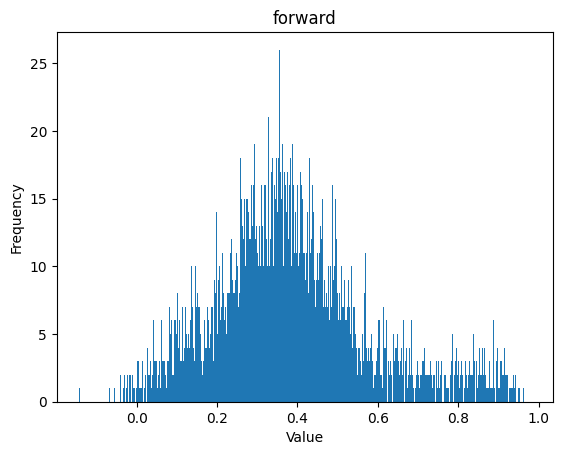

{'mean': 0.38718041170625517,
 'median': 0.363653568333263,
 'minimum': -0.14212758475771817,
 'maximum': 0.9790910995883623,
 'q1': 0.2600543530074316,
 'q3': 0.4856668295265922}

In [25]:
plot_hist(corvec_forward, 1000, title="forward")
get_summary(corvec_forward)

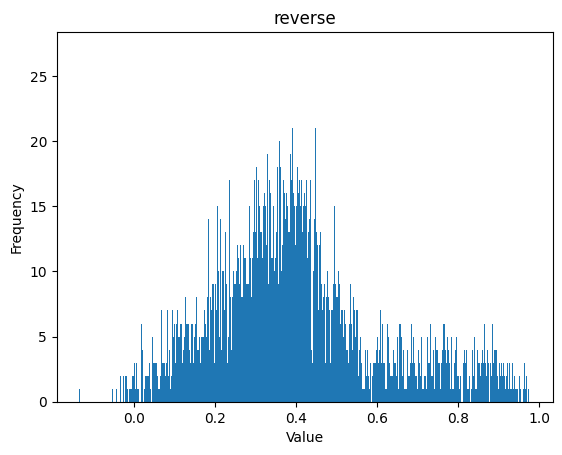

{'mean': 0.40360321051079723,
 'median': 0.3729163891112569,
 'minimum': -0.13450596082088287,
 'maximum': 0.9787238316933228,
 'q1': 0.26656786415174694,
 'q3': 0.5046657045156163}

In [27]:
plot_hist(corvec_revflip, 1000, title="reverse")
get_summary(corvec_revflip)

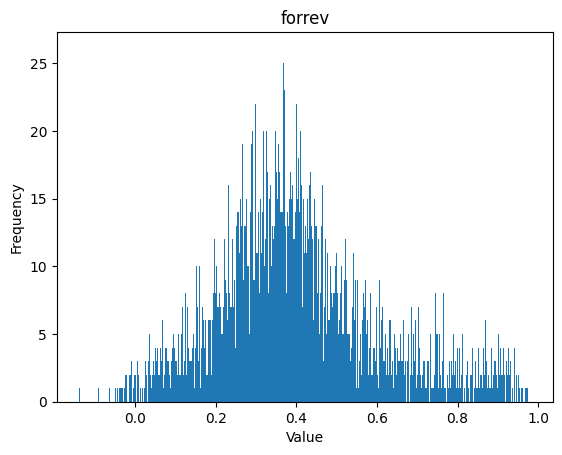

{'mean': 0.40251886290533295,
 'median': 0.37566488716013463,
 'minimum': -0.13894071497942373,
 'maximum': 0.980877195481625,
 'q1': 0.2687798375206835,
 'q3': 0.5078606089010983}

In [28]:
plot_hist(corvec_forrev, 1000, title="forrev")
get_summary(corvec_forrev)

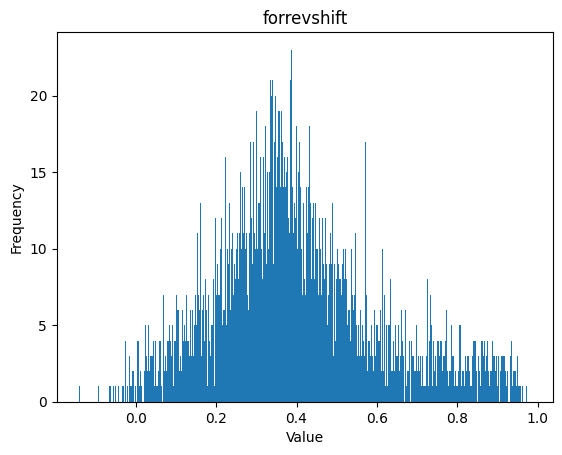

{'mean': 0.4054838451596735,
 'median': 0.3781294978904418,
 'minimum': -0.13983302881054696,
 'maximum': 0.9813297030486948,
 'q1': 0.2714992025134109,
 'q3': 0.5103938190048124}

In [18]:
plot_hist(corvec_forrevshift, 1000, title="forrevshift")
get_summary(corvec_forrevshift)

the forward reverse and shifted average matrix has the highest mean, median, q1, and q1 of column correlations

Conclusion: the forrevshift matrix will give you the closest results to the ground truth, so that's what we will be using for our predictions

## Comparing 100 gtruths to predtypes

In [55]:
# get intervals that contain tss
    

array([[       10,  37555537,  37686609],
       [       14,  87048845,  87179917],
       [        0, 136527085, 136658157],
       ...,
       [       19,  30681544,  30812616],
       [       14,  61473198,  61604270],
       [        2, 129664471, 129795543]])

In [5]:
# read in tss data from hackathon 

chr1_tss = pd.read_table('/grand/TFXcan/imlab/users/lvairus/hackenf/data/tss_by_chr/chr1_tss_by_gene.txt', sep='\t')
chr2_tss = pd.read_table('/grand/TFXcan/imlab/users/lvairus/hackenf/data/tss_by_chr/chr2_tss_by_gene.txt', sep='\t')
chr3_tss = pd.read_table('/grand/TFXcan/imlab/users/lvairus/hackenf/data/tss_by_chr/chr3_tss_by_gene.txt', sep='\t')
chr4_tss = pd.read_table('/grand/TFXcan/imlab/users/lvairus/hackenf/data/tss_by_chr/chr4_tss_by_gene.txt', sep='\t')
chr5_tss = pd.read_table('/grand/TFXcan/imlab/users/lvairus/hackenf/data/tss_by_chr/chr5_tss_by_gene.txt', sep='\t')
chr6_tss = pd.read_table('/grand/TFXcan/imlab/users/lvairus/hackenf/data/tss_by_chr/chr6_tss_by_gene.txt', sep='\t')
chr7_tss = pd.read_table('/grand/TFXcan/imlab/users/lvairus/hackenf/data/tss_by_chr/chr7_tss_by_gene.txt', sep='\t')
chr8_tss = pd.read_table('/grand/TFXcan/imlab/users/lvairus/hackenf/data/tss_by_chr/chr8_tss_by_gene.txt', sep='\t')
chr9_tss = pd.read_table('/grand/TFXcan/imlab/users/lvairus/hackenf/data/tss_by_chr/chr9_tss_by_gene.txt', sep='\t')
chr10_tss = pd.read_table('/grand/TFXcan/imlab/users/lvairus/hackenf/data/tss_by_chr/chr10_tss_by_gene.txt', sep='\t')
chr11_tss = pd.read_table('/grand/TFXcan/imlab/users/lvairus/hackenf/data/tss_by_chr/chr11_tss_by_gene.txt', sep='\t')
chr12_tss = pd.read_table('/grand/TFXcan/imlab/users/lvairus/hackenf/data/tss_by_chr/chr12_tss_by_gene.txt', sep='\t')
chr13_tss = pd.read_table('/grand/TFXcan/imlab/users/lvairus/hackenf/data/tss_by_chr/chr13_tss_by_gene.txt', sep='\t')
chr14_tss = pd.read_table('/grand/TFXcan/imlab/users/lvairus/hackenf/data/tss_by_chr/chr14_tss_by_gene.txt', sep='\t')
chr15_tss = pd.read_table('/grand/TFXcan/imlab/users/lvairus/hackenf/data/tss_by_chr/chr15_tss_by_gene.txt', sep='\t')
chr16_tss = pd.read_table('/grand/TFXcan/imlab/users/lvairus/hackenf/data/tss_by_chr/chr16_tss_by_gene.txt', sep='\t')
chr17_tss = pd.read_table('/grand/TFXcan/imlab/users/lvairus/hackenf/data/tss_by_chr/chr17_tss_by_gene.txt', sep='\t')
chr18_tss = pd.read_table('/grand/TFXcan/imlab/users/lvairus/hackenf/data/tss_by_chr/chr18_tss_by_gene.txt', sep='\t')
chr19_tss = pd.read_table('/grand/TFXcan/imlab/users/lvairus/hackenf/data/tss_by_chr/chr19_tss_by_gene.txt', sep='\t')
chr20_tss = pd.read_table('/grand/TFXcan/imlab/users/lvairus/hackenf/data/tss_by_chr/chr20_tss_by_gene.txt', sep='\t')
chr21_tss = pd.read_table('/grand/TFXcan/imlab/users/lvairus/hackenf/data/tss_by_chr/chr21_tss_by_gene.txt', sep='\t')
chr22_tss = pd.read_table('/grand/TFXcan/imlab/users/lvairus/hackenf/data/tss_by_chr/chr22_tss_by_gene.txt', sep='\t')
chrX_tss = pd.read_table('/grand/TFXcan/imlab/users/lvairus/hackenf/data/tss_by_chr/chrX_tss_by_gene.txt', sep='\t')
chrY_tss = pd.read_table('/grand/TFXcan/imlab/users/lvairus/hackenf/data/tss_by_chr/chrY_tss_by_gene.txt', sep='\t')

In [6]:
chr1_tss

,genes,txStart_Sites,strand
0,DDX11L1,"11869, 11872, 11874, 12010",+
1,WASH7P,"29370, 24886, 29370, 29570, 29806, 19305, 29344",-
2,MIR1302-11,"29554, 30267, 30366",+
3,FAM138A,"36081, 36073",-
4,OR4G11P,62948,+
...,...,...,...
4800,ZNF672,"249132409, 249132479, 249132530, 249133027, 24...",+
4801,ZNF692,"249152912, 249153271, 249153271, 249153271, 24...",-
4802,AL672294.1,249153363,+
4803,PGBD2,"249200395, 249200442, 249200464, 249200571",+


In [7]:
# get list canonical tss

chrX_canon_tss = chrX_tss["txStart_Sites"].str.split(',').str[0].values.astype(int)
chr1_canon_tss = chr1_tss["txStart_Sites"].str.split(',').str[0].values.astype(int)
chr2_canon_tss = chr2_tss["txStart_Sites"].str.split(',').str[0].values.astype(int)
chr3_canon_tss = chr3_tss["txStart_Sites"].str.split(',').str[0].values.astype(int)
chr4_canon_tss = chr4_tss["txStart_Sites"].str.split(',').str[0].values.astype(int)
chr5_canon_tss = chr5_tss["txStart_Sites"].str.split(',').str[0].values.astype(int)
chr6_canon_tss = chr6_tss["txStart_Sites"].str.split(',').str[0].values.astype(int)
chr7_canon_tss = chr7_tss["txStart_Sites"].str.split(',').str[0].values.astype(int)
chr8_canon_tss = chr8_tss["txStart_Sites"].str.split(',').str[0].values.astype(int)
chr9_canon_tss = chr9_tss["txStart_Sites"].str.split(',').str[0].values.astype(int)
chr10_canon_tss = chr10_tss["txStart_Sites"].str.split(',').str[0].values.astype(int)
chr11_canon_tss = chr11_tss["txStart_Sites"].str.split(',').str[0].values.astype(int)
chr12_canon_tss = chr12_tss["txStart_Sites"].str.split(',').str[0].values.astype(int)
chr13_canon_tss = chr13_tss["txStart_Sites"].str.split(',').str[0].values.astype(int)
chr14_canon_tss = chr14_tss["txStart_Sites"].str.split(',').str[0].values.astype(int)
chr15_canon_tss = chr15_tss["txStart_Sites"].str.split(',').str[0].values.astype(int)
chr16_canon_tss = chr16_tss["txStart_Sites"].str.split(',').str[0].values.astype(int)
chr17_canon_tss = chr17_tss["txStart_Sites"].str.split(',').str[0].values.astype(int)
chr18_canon_tss = chr18_tss["txStart_Sites"].str.split(',').str[0].values.astype(int)
chr19_canon_tss = chr19_tss["txStart_Sites"].str.split(',').str[0].values.astype(int)
chr20_canon_tss = chr20_tss["txStart_Sites"].str.split(',').str[0].values.astype(int)
chr21_canon_tss = chr21_tss["txStart_Sites"].str.split(',').str[0].values.astype(int)
chr22_canon_tss = chr22_tss["txStart_Sites"].str.split(',').str[0].values.astype(int)

all_canon_tss = [chrX_canon_tss, chr1_canon_tss, chr2_canon_tss, chr3_canon_tss, chr4_canon_tss, chr5_canon_tss, chr6_canon_tss, chr7_canon_tss, chr8_canon_tss, chr9_canon_tss, chr10_canon_tss, chr11_canon_tss, chr12_canon_tss, chr13_canon_tss, chr14_canon_tss, chr15_canon_tss, chr16_canon_tss, chr17_canon_tss, chr18_canon_tss, chr19_canon_tss, chr20_canon_tss, chr21_canon_tss, chr22_canon_tss]


In [76]:
canon_tss = chr1_canon_tss
chr_intervals = intervals[intervals[:, 0] == 1]
for interval in chr_intervals:
    start = interval[1]
    end = interval[2]
    
    canon_tss[canon_tss >= start]

37686609

In [133]:



chr_num = 1
canon_tss = chr1_canon_tss
chr_intervals = intervals[intervals[:, 0] == chr_num]
interval = chr_intervals[0]
start = interval[1]
end = interval[2]

filtered_tss1 = canon_tss[canon_tss >= start]
filtered_tss2 = filtered_tss1[filtered_tss1 <= end]

print(start, end, filtered_tss2)
if any(filtered_tss2):
    print("true")

228608364 228739436 []


In [8]:
intervals_with_tss_list = []

for chr_num, canon_tss in enumerate(all_canon_tss):
    chr_intervals = intervals[intervals[:, 0] == chr_num]

    for interval in chr_intervals:
        start = interval[1]
        end = interval[2]

        filtered_tss = canon_tss[(canon_tss >= start) & (canon_tss <= end)]
        
        if any(filtered_tss):
            intervals_with_tss_list.append(interval)



In [10]:
intervals_with_tss = np.array(intervals_with_tss_list)

In [11]:
intervals_with_tss[:10]

array([[        0, 136527085, 136658157],
       [        0, 117971834, 118102906],
       [        0,   4464454,   4595526],
       ...,
       [       22,  21003344,  21134416],
       [       22,  21691478,  21822550],
       [       22,  19397698,  19528770]])

In [9]:
# Generate random indices for sampling

np.random.seed(2)
# get 100 random indices
random_indices = np.random.randint(0, len(intervals_with_tss), size=100)

# add indices of intervals from chromosomes that weren't first sampled (gotten manually)
more_indicies = np.array([289,418,426,613,1227,1228])
random_indices = np.concatenate([random_indices, more_indicies])

# Use the random indices to select random intervals
random_intervals = intervals_with_tss[random_indices]
set(random_intervals[:,0])


NameError: name 'np' is not defined

In [89]:
intervals_with_tss[289+9+15+105+1+7+6+12+6+151+12+8+571+35+1]

array([      17, 20693681, 20824753])

In [45]:
Counter(intervals_with_tss[:,0])

Counter({0: 289,
         1: 9,
         2: 15,
         3: 105,
         4: 1,
         6: 7,
         7: 6,
         8: 12,
         10: 6,
         11: 151,
         12: 12,
         13: 8,
         14: 571,
         15: 35,
         16: 1,
         17: 2,
         19: 226,
         22: 26})

In [94]:
random_intervals

array([[       15,  25341276,  25472348],
       [       11,  31633880,  31764952],
       [       11,  34845172,  34976244],
       [        2, 129320404, 129451476],
       [       11,  38400531,  38531603],
       [       14,  51036499,  51167571],
       [        3, 195743498, 195874570],
       [       19,  36645372,  36776444],
       [       14,  50577743,  50708815],
       [        8, 144614851, 144745923],
       [       12,  11085476,  11216548],
       [       11,  32895459,  33026531],
       [       14,  35324106,  35455178],
       [       14,  70418940,  70550012],
       [       14,  79135304,  79266376],
       [       19,   9779312,   9910384],
       [       14,  88425113,  88556185],
       [        3, 183815842, 183946914],
       [        0, 119348102, 119479174],
       [       14,  22823005,  22954077],
       [       14,  69501428,  69632500],
       [       15,  27176300,  27307372],
       [       14,  31998125,  32129197],
       [       14,  94733008,  948

In [101]:
random_interval_strings_shifted = [None] * len(random_intervals) * 3

for j, interval in enumerate(random_intervals):
    i = j * 3
    random_interval_strings_shifted[i] = f'chr{interval[0]}_{interval[1]-3}_{interval[2]-3}'
    random_interval_strings_shifted[i+1] = f'chr{interval[0]}_{interval[1]}_{interval[2]}'
    random_interval_strings_shifted[i+2] = f'chr{interval[0]}_{interval[1]+3}_{interval[2]+3}'

random_interval_strings_shifted[:20]

['chr15_25341273_25472345',
 'chr15_25341276_25472348',
 'chr15_25341279_25472351',
 'chr11_31633877_31764949',
 'chr11_31633880_31764952',
 'chr11_31633883_31764955',
 'chr11_34845169_34976241',
 'chr11_34845172_34976244',
 'chr11_34845175_34976247',
 'chr2_129320401_129451473',
 'chr2_129320404_129451476',
 'chr2_129320407_129451479',
 'chr11_38400528_38531600',
 'chr11_38400531_38531603',
 'chr11_38400534_38531606',
 'chr14_51036496_51167568',
 'chr14_51036499_51167571',
 'chr14_51036502_51167574',
 'chr3_195743495_195874567',
 'chr3_195743498_195874570']

In [105]:
# making the interval txt file for enformer pipeline

with open('/grand/TFXcan/imlab/users/lvairus/shared_folder/enformer_pipeline/metadata/test_predtype_intervals.txt', 'w') as f:
    for interval in random_intervals:
        f.write(f'"chr{interval[0]}_{interval[1]-3}_{interval[2]-3}"\n')
        f.write(f'"chr{interval[0]}_{interval[1]}_{interval[2]}"\n')
        f.write(f'"chr{interval[0]}_{interval[1]+3}_{interval[2]+3}"\n')

In [108]:
intervals_with_tss[random_indices] == random_intervals

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ T

In [ ]:
def make_predtypes(index, interval):

    with h5py.File("/grand/TFXcan/imlab/users/lvairus/reftile_project/predictions_folder/chr17_reference_avg6_shifted_regions/predictions_2023-08-15/chr17_predictions/chr17_reference_avg6/haplotype0/chr17_20693678_20824750_predictions.h5") as f:
        shift_down = f['chr17_20693678_20824750'][()]

    with h5py.File("/grand/TFXcan/imlab/users/lvairus/reftile_project/predictions_folder/chr17_reference_avg6_shifted_regions/predictions_2023-08-15/chr17_predictions/chr17_reference_avg6/haplotype0_rc/chr17_20693678_20824750_predictions.h5") as f:
        shift_down_rev = f['chr17_20693678_20824750'][()]
        shift_down_revflip = np.flipud(shift_down_rev)

    with h5py.File(f"/grand/TFXcan/imlab/users/lvairus/reftile_project/predictions_folder/reference_rcshift_shifted_regions/predictions_2023-08-17/predictions/reference_rcshift/haplotype0/{interval}_predictions.h5") as f:
        no_shift = f[interval][()]

    with h5py.File(f"/grand/TFXcan/imlab/users/lvairus/reftile_project/predictions_folder/reference_rcshift_shifted_regions/predictions_2023-08-17/predictions/reference_rcshift/haplotype0_rc/{interval}_predictions.h5") as f:
        no_shift_rev = f[interval][()]
        no_shift_revflip = np.flipud(no_shift_rev)

    with h5py.File("/grand/TFXcan/imlab/users/lvairus/reftile_project/predictions_folder/chr17_reference_avg6_shifted_regions/predictions_2023-08-15/chr17_predictions/chr17_reference_avg6/haplotype0/chr17_20693684_20824756_predictions.h5") as f:
        shift_up = f['chr17_20693684_20824756'][()]

    with h5py.File("/grand/TFXcan/imlab/users/lvairus/reftile_project/predictions_folder/chr17_reference_avg6_shifted_regions/predictions_2023-08-15/chr17_predictions/chr17_reference_avg6/haplotype0_rc/chr17_20693684_20824756_predictions.h5") as f:
        shift_up_rev = f['chr17_20693684_20824756'][()]
        shift_up_revflip = np.flipud(shift_up_rev)

    forrev_avg = (forward + revflip) / 2
    shifted_avg = (no_shift + no_shift_revflip + shift_down + shift_down_revflip + shift_up + shift_up_revflip) / 6

    with h5py.File("/grand/TFXcan/imlab/data/enformer_training_data/basenji_data_h5/no_groups_popseq_revised_order/test_pop_seq.hdf5") as f:
        gtruth = f['target'][index]

    return (forward, reverse, forrev_avg, shifted_avg, gtruth)

In [2]:
12*4

48

In [ ]:
long_summary_df = pd.DataFrame(columns=['index', 'predtype', 'stattype', 'value'], index=range(5088))
pred_stat_mat = np.zeros((4, 12))

for i in len(random_intervals):
    index = random_indices[i]
    interval = random_intervals[i]

    # get predtypes
    forward, reverse, forrev_avg, shifted_avg, gtruth = make_predtypes(index, interval) # 5 (896, 5313)

    # get reldiffs of each predtype to gtruth
    reldiff_forward = get_diffmat(forward, gtruth) # (896, 5313)
    reldiff_reverse = get_diffmat(reverse, gtruth)
    reldiff_forrev_avg = get_diffmat(forrev_avg, gtruth)
    reldiff_shifted_avg = get_diffmat(shifted_avg, gtruth)

    # get summary stats of each reldiff
    reldiff_forward_stats = get_summary_list(reldiff_forward) # (6)
    reldiff_reverse_stats = get_summary_list(reldiff_reverse)
    reldiff_forrev_avg_stats = get_summary_list(reldiff_forrev_avg)
    reldiff_shifted_avg_stats = get_summary_list(reldiff_shifted_avg)

    # get column correlations of each predtype to gtruth
    colcorvec_forward = get_colcorvec(forward, gtruth) # (5313)
    colcorvec_reverse = get_colcorvec(reverse, gtruth)
    colcorvec_forrev_avg = get_colcorvec(forrev_avg, gtruth)
    colcorvec_shifted_avg = get_colcorvec(shifted_avg, gtruth)

    # get summary stats of each colcorvec
    colcorvec_forward_stats = get_summary_list(colcorvec_forward) # (6)
    colcorvec_reverse_stats = get_summary_list(colcorvec_reverse)
    colcorvec_forrev_avg_stats = get_summary_list(colcorvec_forrev_avg)
    colcorvec_shifted_avg_stats = get_summary_list(colcorvec_shifted_avg)

    # combine stats into 1 vector
    pred_stats_vec = np.concatenate((reldiff_forward_stats, reldiff_reverse_stats, reldiff_forrev_avg_stats, reldiff_shifted_avg_stats, colcorvec_forward_stats, colcorvec_reverse_stats, colcorvec_forrev_avg_stats, colcorvec_shifted_avg_stats), axis=0) # (48)

    # add all values to long_summary_df
    df.loc[48*i:48*(i+1), 'value'] = pred_stats_vec

# loop through index predtype and stattype values to add to long_summary_df
stattype_loop = ['reldiff_min','reldiff_q1','reldiff_med','reldiff_q3','reldiff_max','reldiff_mean','colcorvec_min','colcorvec_q1','colcorvec_median','colcorvec_q3','colcorvec_max','colcorvec_mean','colcorvec_std']
predtype_loop = ['forward','reverse','forrev_avg','shifted_avg']

stattype_loop = stattype_loop*424
predtype_loop = predtype_loop*1272
    

In [7]:
106*48


5088

In [8]:
type(random_indices)

NameError: name 'random_indices' is not defined